In [13]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from Bio import SeqIO
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Lambda, Conv2D, MaxPooling2D
import os
import random
from  keras.regularizers import l2
from sklearn.preprocessing import PowerTransformer


In [14]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

train = pd.read_csv('Embeddings/Prot_t5/train_t5_pssm.csv')
val = pd.read_csv('Embeddings/Prot_t5/val_t5_pssm.csv')
test = pd.read_csv('Embeddings/Prot_t5/test_t5_pssm.csv')

# train = pd.concat([train, val])

print(train.shape)
print(val.shape)
print(test.shape)

# Make validation set imbalanced
val_pos = val[val['label'] == 1]
val_neg = val[val['label'] == 0]

val_pos = val_pos.sample(frac=0.1, random_state=4)

val = pd.concat([val_pos, val_neg])

# Convert the embedding strings to numpy arrays
X_train_embeddings = train['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_val_embeddings = val['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_test_embeddings = test['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))

X_train_PSSM = train['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
X_val_PSSM = val['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))
X_test_PSSM = test['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))

X_train_PSSM = np.stack(X_train_PSSM.values)
X_val_PSSM = np.stack(X_val_PSSM.values)
X_test_PSSM = np.stack(X_test_PSSM.values)

# Convert to a numpy array if needed
X_train_embeddings = np.stack(X_train_embeddings.values)
X_val_embeddings = np.stack(X_val_embeddings.values)
X_test_embeddings = np.stack(X_test_embeddings.values)

# use power transform to normalize the pssm
scaler = PowerTransformer()
X_train_PSSM = scaler.fit_transform(X_train_PSSM)
X_val_PSSM = scaler.transform(X_val_PSSM)
X_test_PSSM = scaler.transform(X_test_PSSM)

# Extract sequences
X_train = train['sequence'].values
X_val = val['sequence'].values
X_test = test['sequence'].values

# Extract labels
y_train = train['label'].values
y_val = val['label'].values
y_test = test['label'].values

# Create a dictionary to map amino acids to integers
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Convert the sequences to a numerical format and convert to numpy arrays
X_train_num = [[aa_to_int[aa] for aa in seq] for seq in X_train]
X_val_num = [[aa_to_int[aa] for aa in seq] for seq in X_val]
X_test_num = [[aa_to_int[aa] for aa in seq] for seq in X_test]

X_train_num = np.array(X_train_num)
X_val_num = np.array(X_val_num)
X_test_num = np.array(X_test_num)

#print shapes
print(X_train_embeddings.shape)
print(X_val_embeddings.shape)
print(X_test_embeddings.shape)
print(X_train_PSSM.shape)
print(X_val_PSSM.shape)
print(X_test_PSSM.shape)
print(X_train_num.shape)
print(X_val_num.shape)
print(X_test_num.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)



(8411, 6)
(935, 6)
(3226, 6)
(8411, 1024)
(490, 1024)
(3226, 1024)
(8411, 20)
(490, 20)
(3226, 20)
(8411, 33)
(490, 33)
(3226, 33)
(8411,)
(490,)
(3226,)


In [15]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def evaluate_model(model, X_val = None, X_val_pt5 = None, X_val_PSSM = None, y_val = None, print_metrics=True):
    y_true = y_val
    # Predict probabilities (or logits if using `from_logits=True`).
    if X_val_pt5 is None:
        y_pred_probs = model.predict(X_val)
    elif X_val is None:
        y_pred_probs = model.predict(X_val_pt5)
    elif X_val_PSSM is None:
        y_pred_probs = model.predict([X_val, X_val_pt5])
    else:
        y_pred_probs = model.predict([X_val, X_val_pt5, X_val_PSSM])

    # Convert probabilities/logits to binary predictions (threshold = 0.5).
    y_pred = (y_pred_probs > 0.5).astype(int)

    # If y_true is one-hot encoded, convert it to binary format
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
        y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded y_true to binary labels

    # Ensure y_pred is also 1D
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # Convert y_pred to binary labels if necessary

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    auprc = average_precision_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Compute Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results
    if print_metrics:
        print(f'Accuracy: {accuracy:.4f}')
        print(f'MCC: {mcc:.4f}')
        print(f'AUC: {auc:.4f}')
        print(f'AUPRC: {auprc:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'Specificity: {specificity:.4f}')
        print(f'F1 Score: {f1:.4f}')

    return accuracy, mcc, auc, auprc, precision, recall, specificity, f1

In [16]:
from keras.models import Model
from keras.layers import Input, Embedding, SimpleRNN, Dense, Dropout, Flatten

def create_rnn_model():
    # RNN branch for sequence data
    input_shape_rnn = (33,)  # Example shape, adjust according to your input
    rnn_input = Input(shape=input_shape_rnn)
    x_rnn = Embedding(input_dim=64, output_dim=21)(rnn_input)  # Embedding layer
    x_rnn = SimpleRNN(32, activation='relu')(x_rnn)  # RNN layer

    # Dense layer for sequence features
    x_rnn = Dense(32, activation='relu')(x_rnn)  # Dense layer
    x_rnn = Dropout(0.3)(x_rnn)  # Dropout for regularization

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(x_rnn)  # Output layer

    # Create the model
    rnn_model = Model(inputs=rnn_input, outputs=output_layer)
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return rnn_model

In [17]:
from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout

def create_bilstm_model():
    # BiLSTM branch for sequence data
    input_shape_bilstm = (33,)  # Example shape, adjust according to your input
    bilstm_input = Input(shape=input_shape_bilstm)
    x_bilstm = Embedding(input_dim=64, output_dim=21)(bilstm_input)  # Embedding layer
    x_bilstm = LSTM(32, return_sequences=False)(x_bilstm)  # BiLSTM layer

    # Dense layer for sequence features
    x_bilstm = Dense(64, activation='relu')(x_bilstm)  # Dense layer
    x_bilstm = Dropout(0.3)(x_bilstm)  # Dropout for regularization

    # Output layer
    x_bilstm = Dense(1, activation='sigmoid')(x_bilstm)  # Output layer

    # Create the model
    bilstm_model = Model(inputs=bilstm_input, outputs=x_bilstm)
    bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return bilstm_model

In [18]:
from keras.models import Model
from keras.layers import Input, Embedding, Dense, Dropout, Flatten

def create_fnn_model():
    # FNN branch for sequence data
    input_shape_fnn = (33,)  # Example shape, adjust according to your input
    fnn_input = Input(shape=input_shape_fnn)
    x_fnn = Embedding(input_dim=64, output_dim=21)(fnn_input)  # Embedding layer

    # Flatten the embedded input to feed into dense layers
    x_fnn = Flatten()(x_fnn)  # Flatten the output of the embedding layer

    # Dense layers for sequence features
    x_fnn = Dense(64, activation='relu')(x_fnn)  # First Dense layer
    x_fnn = Dropout(0.3)(x_fnn)  # Dropout for regularization
    x_fnn = Dense(32, activation='relu')(x_fnn)  # Second Dense layer
    x_fnn = Dropout(0.3)(x_fnn)  # Dropout for regularization
    x_fnn = Dense(1, activation='sigmoid')(x_fnn)  # Output layer for binary classification

    # Create the model
    fnn_model = Model(inputs=fnn_input, outputs=x_fnn)
    fnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return fnn_model

In [19]:
def create_conv1D_model():
    # Conv1D branch for sequence data
    input_shape_conv1d = (33,)  # Example shape, adjust according to your input
    conv1d_input = Input(shape=input_shape_conv1d)
    x_conv1d = Embedding(input_dim=64, output_dim=21)(conv1d_input)  # Embedding layer
    x_conv1d = Conv1D(32, 3, activation='relu')(x_conv1d)  # Conv1D layer
    x_conv1d = Flatten()(x_conv1d)  # Flatten the output of the Conv1D layer

    # Dense layers for sequence features
    x_conv1d = Dense(32, activation='relu')(x_conv1d)  # Dense layer
    x_conv1d = Dropout(0.3)(x_conv1d)  # Dropout for regularization

    # Output layer
    x_conv1d = Dense(1, activation='sigmoid')(x_conv1d)  # Output layer

    # Create the model
    conv1d_model = Model(inputs=conv1d_input, outputs=x_conv1d)
    conv1d_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return conv1d_model

In [20]:
def create_conv2D_model():
    conv_input = Input(shape=(33,), name='conv_input')

    # Embedding layer
    x = Embedding(input_dim=64, output_dim=21)(conv_input)

    x = Lambda(lambda x: tf.expand_dims(x, 3))(x)

    # Convolutional layers
    x = Conv2D(32, kernel_size=(3, 3), activation='relu',
               kernel_initializer='he_normal', padding='VALID')(x)
    x = Flatten()(x)

    x = Dense(32, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.3)(x)

    # Output layer
    x = Dense(1, activation='sigmoid')(x)
    
    conv2D_model = Model(inputs=conv_input, outputs=x)
    conv2D_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return conv2D_model

In [21]:
def inception_module(input_tensor):
    # Branch 1: Conv1D with kernel size 1
    branch1 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(input_tensor)

    # Branch 2: Conv1D with kernel size 3
    branch2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_tensor)

    # Branch 3: Conv1D with kernel size 5
    branch3 = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_tensor)

    # Branch 4: Conv1D with kernel size 7
    branch4 = Conv1D(32, kernel_size=7, activation='relu', padding='same')(input_tensor)

    # Branch 5: Conv1D with kernel size 9
    branch5 = Conv1D(32, kernel_size=9, activation='relu', padding='same')(input_tensor)

    # Branch 6: Conv1D with kernel size 11
    branch6 = Conv1D(32, kernel_size=11, activation='relu', padding='same')(input_tensor)

    # Branch 6: MaxPooling + Conv1D with kernel size 1
    branch7 = MaxPooling1D(pool_size=2, strides=1, padding='same')(input_tensor)
    branch7 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(branch7)


    # Concatenate all branches
    output = Concatenate()([branch1, branch2, branch3, branch4, branch5, branch6, branch7])
    return output

def create_inception_model():
    # Conv1D branch for sequence data
    input_shape_conv = (33,)  # Example shape, adjust according to your input
    conv_input = Input(shape=input_shape_conv)

    # Embedding layer
    x_conv = Embedding(input_dim=64, output_dim=21)(conv_input)

    # Apply Inception module instead of Conv1D
    x_conv = inception_module(x_conv)

    # MaxPooling and Flatten layers
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    output_conv = Dense(1, activation='sigmoid')(x_conv)

    # Create the model
    conv_model = Model(inputs=conv_input, outputs=output_conv)
    conv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return conv_model


In [22]:
def residual_block(input_tensor, filters):
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(x)
    x = Concatenate()([x, input_tensor])  # Skip connection
    return x

def create_res_model():
    # Conv1D branch for sequence data
    input_shape_conv = (33,)  # Example shape, adjust according to your input
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=21, output_dim=21)(conv_input)

    # Apply Residual blocks
    x_conv = residual_block(x_conv, 32)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = residual_block(x_conv, 64)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    output_conv = Dense(1, activation='sigmoid')(x_conv)

    # Create the model
    res_model = Model(inputs=conv_input, outputs=output_conv)
    res_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return res_model

In [23]:
rnn_model = create_rnn_model()
bilstm_model = create_bilstm_model()
fnn_model = create_fnn_model()
conv1d_model = create_conv1D_model()
conv2D_model = create_conv2D_model()
inception_model = create_inception_model()
res_model = create_res_model()

epochs = 100
batch_size = 64
patience = 10

set_seed(4)
# Train the models
rnn_model.fit(X_train_num, y_train, validation_data=(X_val_num, y_val), epochs=epochs, batch_size=batch_size, verbose=0,
                callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])
bilstm_model.fit(X_train_num, y_train, validation_data=(X_val_num, y_val), epochs=epochs, batch_size=batch_size, verbose=0,
                callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])
fnn_model.fit(X_train_num, y_train, validation_data=(X_val_num, y_val), epochs=epochs, batch_size=batch_size, verbose=0,
                callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])
conv1d_model.fit(X_train_num, y_train, validation_data=(X_val_num, y_val), epochs=epochs, batch_size=batch_size, verbose=0,
                callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])
conv2D_model.fit(X_train_num, y_train, validation_data=(X_val_num, y_val), epochs=epochs, batch_size=batch_size, verbose=0,
                callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])
inception_model.fit(X_train_num, y_train, validation_data=(X_val_num, y_val), epochs=epochs, batch_size=batch_size, verbose=0,
                callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])
res_model.fit(X_train_num, y_train, validation_data=(X_val_num, y_val), epochs=epochs, batch_size=batch_size, verbose=0,
                callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])

--- RNN ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.7429
MCC: 0.1324
AUC: 0.5941
AUPRC: 0.2293
Precision: 0.1709
Recall: 0.4082
Specificity: 0.7800
F1 Score: 0.2410
--- BiLSTM ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy: 0.7041
MCC: 0.3492
AUC: 0.7812
AUPRC: 0.3270
Precision: 0.2363
Recall: 0.8776
Specificity: 0.6848
F1 Score: 0.3723
--- FNN ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.7163
MCC: 0.2433
AUC: 0.6882
AUPRC: 0.3626
Precision: 0.2078
Recall: 0.6531
Specificity: 0.7234
F1 Score: 0.3153
--- Conv1D ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7776
MCC: 0.2736
AUC: 0.6950
AUPRC: 0.3539
Precision: 0.2458
Recall: 0.5918
Specificity: 0.7982
F1 Score: 0.3473
--- Conv2D ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7776
MCC: 0.2736
AUC: 0.6950
AUPRC: 0.3949
Precision: 0.2458
Recall: 0.5918
Specificity: 0.7982
F1 Score: 0.3473
--- Inception ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.7959
MCC: 0.3182
AUC: 0.7234
AUPRC: 0.36

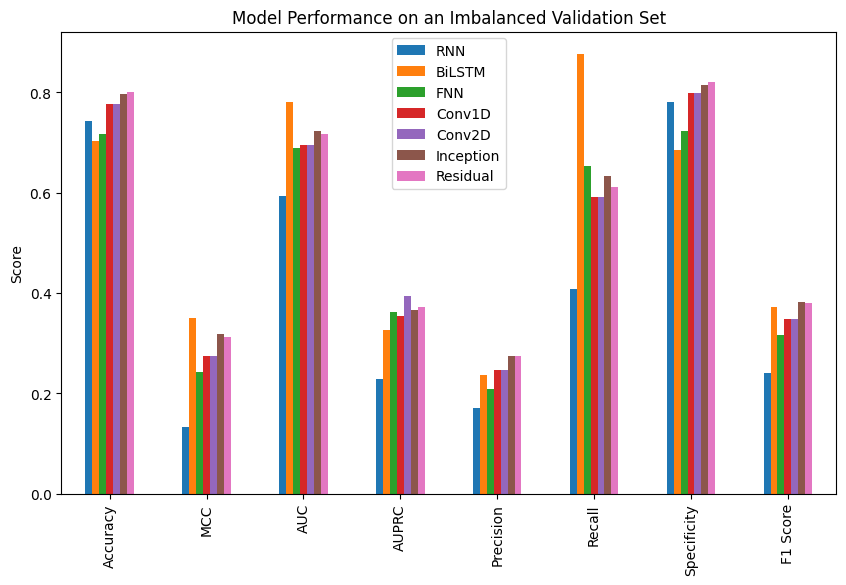

In [24]:

# Create dictionary to store the results
results = {}

model_names = ['RNN', 'BiLSTM', 'FNN', 'Conv1D', 'Conv2D', 'Inception', 'Residual']
models = [rnn_model, bilstm_model, fnn_model, conv1d_model, conv2D_model, inception_model, res_model]

# Evaluate the models
for model_name, model in zip(model_names, models):
    print(f'--- {model_name} ---')
    results[model_name] = evaluate_model(model, X_val=X_val_num, y_val=y_val)

# Plot the results for comparison
metrics = ['Accuracy', 'MCC', 'AUC', 'AUPRC', 'Precision', 'Recall', 'Specificity', 'F1 Score']
results_df = pd.DataFrame(results, index=metrics)

results_df.plot(kind='bar', figsize=(10, 6), ylabel='Score', title='Model Performance on an Imbalanced Validation Set')
#save the plot
plt.savefig('word_embedding_models.pdf', format='pdf', bbox_inches='tight')